#**0. Installation de Tenserflow**

In [1]:
!pip install tensorflow

#**1. Vérifier les ressources GPU**

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: "+tf.__version__)

2024-02-27 00:05:51.775898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 00:05:51.775974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 00:05:51.905018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 00:05:52.167910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 00:05:54.293891: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Tensorflow version: 2.15.0


2024-02-27 00:05:57.598422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 00:05:58.012228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 00:05:58.012325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import sys
print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.15.0

Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
GPU is available


#**2. Importation des librairies**

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time
from dotmap import DotMap

#**3. Connection à Google Drive**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

#**4. Definition de la fonction shiftYValues : Décale les valeurs y du profil**

In [6]:
def pad_to_same_size(data):
    """
    Ajoute un padding aux données pour qu'elles aient toutes la même taille, en utilisant un mode de padding symétrique.
    """
    max_length = max(len(d) for d in data)  # Trouve la longueur maximale
    return [tf.pad(d, paddings=[[0, max_length - len(d)]], mode='SYMMETRIC') if len(d) < max_length else d for d in data]


#**5.Augmentation des données** 

In [7]:
# Rotate the signal 
def rotate(signal, degree, random=False):
    # Translate the signal's index to the center
    center = np.mean(signal.index)
    translated_signal = signal.copy()
    translated_signal.index = translated_signal.index - center

    if (random):
      # Generate a random degree between -0.2 and 0.2
      degree = np.random.uniform(-degree, degree)
    # Perform rotation around the center
    theta = degree * np.pi / 180
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    # Rotate each point individually
    rotated_values = np.dot(R, [translated_signal.index, translated_signal])

    # Translate the rotated signal back to its original position
    rotated_index = rotated_values[0] + center

    return pd.Series(rotated_values[1], index=rotated_index)

def shift_data_y(signal): 
    return signal.copy() + np.random.uniform(-5, 5)

def shift_data_x(signal):
    shift_amount = np.random.randint(1, 21)  # Random shift amount between 1 and 20
    shift_direction = np.random.choice([1, -1])  # Randomly select shift direction (1 for right, -1 for left)
    
    if shift_direction == 1:  # Shift to the right
        shifted_data = np.concatenate((np.zeros(shift_amount), signal.iloc[:-shift_amount]))
    else:  # Shift to the left
        shifted_data = np.concatenate((signal.iloc[shift_amount:], np.zeros(shift_amount)))
    
    return shifted_data
def add_noise(signal):
    # Add random noise to the signal
    noise_level =0.05 # Adjust noise level as needed
    noise = np.random.normal(scale=noise_level, size=signal.shape)
    noisy_signal = signal.copy() + noise
    return noisy_signal


In [8]:
def random_augmentation(signal):

    # Generate random True or False values for each augmentation technique
    random_rotate = np.random.choice([True, False])
    random_shift_x = np.random.choice([True, False])
    random_shift_y = np.random.choice([True, False])
    random_noise = np.random.choice([True, False])

    augmented_x = signal.copy()

    # Ensure at least one augmentation technique is selected
    if not (random_rotate or random_shift_x or random_noise or random_shift_y):
        random_noise = True

    # Apply each augmentation technique based on the generated random values
    if random_rotate:
        augmented_x = rotate(augmented_x, 0.9,True)
    if random_shift_x:
        augmented_x = shift_data_x(augmented_x)
    if random_shift_y:
        augmented_x = shift_data_y(augmented_x)
    if random_noise:
        augmented_x = add_noise(augmented_x)

    return augmented_x

def augment(data, target):
    augmented_x = data.copy()
    augmented_y = target.copy()

    augmentations = [
        ('vertical flip', lambda x: np.flip(x)), # 4400
        ('horizontal flip', lambda x: rotate(x, 180)), # 8800
        ('rotation', lambda x: rotate(x, 0.9, random=True)), # 17600
        ('shift_y', lambda x: shift_data_y(pd.Series(x))), # 35520
        ('shift_x', lambda x: shift_data_x(pd.Series(x))), # 71040
        ('noise', lambda x: add_noise(pd.Series(x))), # 142080
        ('random', lambda x: random_augmentation(pd.Series(x))) # 284160
    ]

    for name, augmentation in augmentations:
        augmented_data = [np.array(augmentation(pd.Series(x_.flatten()))).reshape(-1, 1) for x_ in augmented_x]
        augmented_x = np.concatenate((augmented_x, augmented_data), axis=0)
        augmented_y = np.append(augmented_y, augmented_y)
        
    return augmented_x, augmented_y

#**6. Traitement des points du fichier CSV : Normalisation**

In [9]:
def process_csv_file(file_path):
    """
    Traite un fichier CSV en triant les points, supprimant les doublons, et ajustant les valeurs y.
    """
    # Charger les points depuis le fichier CSV
    points = pd.read_csv(file_path, names=['x', 'y'])

    # Trier les points par x et supprimer les doublons
    sorted_points = points.sort_values(by='x').drop_duplicates().copy()

    # Filtrer les points pour garder ceux dans la plage spécifiée de x
    # Utiliser .copy() pour éviter SettingWithCopyWarning lors de la modification ultérieure
    sorted_points = sorted_points[(sorted_points.x >= -470) & (sorted_points.x <= 470)].copy()

    # Ajuster les valeurs y sans risque d'avertissement
    sorted_points.loc[:, 'y'] = (sorted_points['y'] + 1200) / 10

    # Retourner les valeurs y ajustées
    return sorted_points.y


#**7. Chargement des profils**

In [10]:
def load_profiles(src):
    """
    Charge tous les profils depuis le répertoire source, les traite et les regroupe avec leurs étiquettes correspondantes.
    """
    classes_id = [d for d in os.listdir(src) if os.path.isdir(os.path.join(src, d))]
    data = []
    target = []
    for classe_id in classes_id:
        dataset_path = os.path.join(src, classe_id)
        files_path = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.csv')]
        for file_path in files_path:
            profil_points = process_csv_file(file_path)
            data.append(profil_points)
            target.append(classe_id)

    padded_data = pad_to_same_size(data)
    return Bunch(data=np.array(padded_data), target=np.array(target))

#**8. Appel du traitement pre-processing**

In [11]:
# Définir le chemin racine du dataset
dataset_root = "/mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/db/"

# Charger les profils depuis les dossiers spécifiés dans le dataset
profiles = load_profiles(dataset_root + "sleepers_db/")
profiles_test = load_profiles(dataset_root + "test/")

# Créer un dictionnaire pour mapper les identifiants uniques des cibles en entiers
id2int = {v: ix for ix, v in enumerate(np.unique(profiles.target))}
int2id = {ix: v for ix, v in enumerate(np.unique(profiles.target))}

# Convertir les cibles en valeurs entières pour faciliter leur manipulation par des algorithmes d'apprentissage automatique
profiles.target = [id2int[val] for val in profiles.target]
profiles_test.target = [id2int[val] for val in profiles_test.target]

2024-02-27 00:06:54.713269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 00:06:54.713399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 00:06:54.713459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 00:06:54.960442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 00:06:54.960536: I external/local_xla/xla/stream_executor

##**8.1 Vérification des données d'entrées x et des classes y correspondantes**

In [12]:
# Supposons que id2int et int2id sont définis comme précédemment
# id2int = {v: ix for ix, v in enumerate(np.unique(profiles.target))}
# int2id = {ix: v for ix, v in id2int.items()}

print("Exemple pour chaque classe unique, avec identifiants numériques et valeurs de classe:")
for unique_class_num in np.unique(profiles.target):
    
    # Trouver l'index du premier exemple de cette classe numérique
    index_of_example = profiles.target.index(unique_class_num)

    # Utiliser int2id pour obtenir la valeur textuelle de la classe à partir de son identifiant numérique
    class_value = int2id[unique_class_num]

    # Afficher l'identifiant et la correspondance de cet exemple
    print(f"\nClasse numérique: {unique_class_num}, Valeur de classe: {class_value}")
    print(f"Index de l'exemple pour cette classe: {index_of_example}")
    print("Données de l'exemple:")
    print(profiles.data[index_of_example])  # Affiche les données de l'exemple
    print(f"Identifiant cible de l'exemple: {profiles.target[index_of_example]}")  # Affiche la cible numérique de l'exemple


Exemple pour chaque classe unique, avec identifiants numériques et valeurs de classe:

Classe numérique: 0, Valeur de classe: BB1
Index de l'exemple pour cette classe: 0
Données de l'exemple:
[-4.22731 -4.17668 -4.3306  -4.2805  -4.29884 -4.4084  -4.3364  -3.99297
 -4.48898 -4.46329 -3.39943 -3.30765 -3.10472 -2.83608 -2.90133 -2.58984
 -2.5006  -2.52212 -2.12539 -2.01567 -2.30151 -2.81053 -3.05599 -3.77423
 -3.79825 -3.59744 -2.6623  -2.35514 -2.40173 -2.03046 -1.92384 -2.16853
 -2.12814 -2.08804 -2.1581  -2.14053 -2.21123 -2.26028 -2.15548 -3.33812
 -3.32177 -3.01504 -4.10176 -4.01813 -3.61871 -3.02075 -2.65009 -2.6358
 -2.644   -2.65248 -2.68345 -2.71472 -2.83533 -3.02346 -3.03345 -3.08844
 -3.099   -3.08746 -4.45581 -4.97269 -3.75181 -3.56064 -2.8676  -4.84897
 -2.28052 -2.27119 -2.37275 -2.3418  -2.31113 -2.12606 -2.14011 -2.22073
 -2.36816 -2.36093 -2.39828 -2.41373 -2.69633 -3.52017 -3.42399 -3.0361
 -3.03066 -3.09277 -2.75209 -2.65814 -2.78761 -3.00726 -2.77944 -2.53036
 -2.083

#**9. Redimenssionement des valeurs x d'entrées pour préparation au modèle Conv1d**

In [13]:
# Extraction des données (features) et des étiquettes (labels) depuis l'ensemble d'entraînement
x, y = profiles.data, profiles.target

# Redimensionnement des données pour ajouter une dimension supplémentaire,
# rendant la forme des données compatible avec certains modèles d'apprentissage profond (ex. modèles CNN qui attendent des données 3D)
x = x.reshape(x.shape[0], x.shape[1], 1)
# Affichage de la nouvelle forme de l'ensemble de données x pour vérification
# La forme résultante est (nombre d'exemples, nombre de features par exemple, 1), ajoutant une dimension 'canal' singleton
print(f'x shape : {x.shape}')

# Extraction des données (features) et des étiquettes (labels) depuis l'ensemble de test
x_test, y_test = profiles_test.data, profiles_test.target

# Même opération de redimensionnement pour l'ensemble de test, pour la cohérence avec l'ensemble d'entraînement
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# Affichage de la nouvelle forme de l'ensemble de données x_test pour vérification
print(f'x_test shape : {x_test.shape}')

x shape : (2220, 437, 1)
x_test shape : (400, 437, 1)


#**10. Définition des modèles Conv1D**

In [14]:
model_params = ({
    'res_block_1': {
        'n_filters': 16,
        'kernel_size': 3,
        'kernel_initializer': 'he_normal',
        'padding': 'same', 
        'activation': 'relu'
    },
    'res_block_2': {
        'n_filters': 32,
        'kernel_size': 3,
        'kernel_initializer': 'he_normal',
        'padding': 'same', 
        'activation': 'relu'
    },
    'res_block_3': {
        'n_filters': 64,
        'kernel_size': 3,
        'kernel_initializer': 'he_normal',
        'padding': 'same', 
        'activation': 'relu'
    }
})

In [15]:
class ResBlock(tf.keras.layers.Layer):

    def __init__(self, params, **kwargs):
        super(ResBlock, self).__init__(**kwargs) 
        self.params = params
        self.bn = tf.keras.layers.BatchNormalization()
        self.cnn = tf.keras.layers.Conv1D(self.params['n_filters'], kernel_size=self.params['kernel_size'], padding=self.params['padding'], 
                                     activation=self.params['activation'], kernel_initializer=self.params['kernel_initializer'])
        self.projection = tf.keras.layers.Conv1D(self.params['n_filters'], kernel_size=1, padding=self.params['padding'], 
                                     activation=self.params['activation'], kernel_initializer=self.params['kernel_initializer'])
        
    def call(self, inputs):
        x = self.cnn(self.bn(inputs))
        return tf.keras.layers.add([x,self.projection(inputs)])

    def get_config(self):
        config = super(ResBlock, self).get_config()
        config.update({'params': self.params})
        return config

In [16]:
def get_model_1(input_shape, num_classes):
    model = Sequential()
    # Première couche convolutive avec 32 filtres et une taille de kernel de 3
    model.add(Conv1D(32, 1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    # Aplatir les données pour les passer à des couches denses
    model.add(Flatten())
    # La couche de sortie avec 'num_classes' unités et activation softmax pour la classification
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [17]:
def get_model_3(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        ResBlock(model_params['res_block_1']),
        tf.keras.layers.MaxPool1D(pool_size=2),
        ResBlock(model_params['res_block_2']),
        tf.keras.layers.MaxPool1D(pool_size=2),
        ResBlock(model_params['res_block_3']),
        # tf.keras.layers.Dropout(0.3), #Removed because we don't have deep layers
        tf.keras.layers.MaxPool1D(pool_size=2), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [18]:
def get_model_2(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(16, kernel_size=3, padding="SAME", activation="elu", kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Conv1D(32, kernel_size=3, padding="SAME", activation="elu", kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Conv1D(64, kernel_size=3, padding="SAME", activation="elu", kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [19]:
def get_model_2(input_shape, num_classes):
    model = Sequential()
    # Première couche convolutive avec 32 filtres et une taille de kernel de 3
    model.add(Conv1D(32, 1,kernel_initializer='he_normal', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation='elu')
    # Ajout d'une couche de pooling pour réduire la dimensionnalité
    model.add(MaxPooling1D(2))
    # # Ajout d'une couche Dropout pour réduire le surapprentissage
    # model.add(Dropout(0.5))  # Ajustez ce taux selon les besoins
    # # Ajout d'une deuxième couche convolutive avec 64 filtres
    # model.add(Conv1D(64, 3, activation='relu'))
    # # Une autre couche de pooling
    # model.add(MaxPooling1D(2))
    # Aplatir les données pour les passer à des couches denses
    model.add(Flatten())
    # # Une couche dense avec 128 unités
    # model.add(Dense(128, activation='relu'))
    # # Ajout d'une autre couche Dropout
    # model.add(Dropout(0.5))  # Ajustez ce taux selon les besoins
    # # La couche de sortie avec 'num_classes' unités et activation softmax pour la classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

#**11. Hyper-parmètres d'optimisation**

In [20]:
# Taille d'entrée basée sur la forme des données x
input_shape = (x.shape[1], x.shape[2])  # (437, 1)

# Nombre de classes à prédire
num_classes = 3

# Batch size
batch_sizes = [32,64,128,256]

# Nbr d'epochs
n_epochs= 100

# Définir le taux d'apprentissage
lr = 0.01 #, 0.001, 0.0001

# Split training and validation
val_split = 0.20

# Early Stopping call Back
early_patience = 50

#**12. Créez le call back**

In [21]:
!mkdir -p model
model_path = "/mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model.h5"

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_patience)

checkpoint = ModelCheckpoint(model_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max', # Ensure that the best model in terms of val_accuracy is saved
                             verbose=1)
reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
callbacks_list = [early_stopping, checkpoint, reduce_lr_on_plateau]

#**13. Entrainement du modèle**

In [23]:
# Enregistrez le temps de départ

start_time_history1 = time.time()

In [24]:
!pip install DotMap

In [25]:
# Assurez-vous que `dict` est initialisé correctement quelque part dans votre code
results_dict = {}  # Utilisez un nom autre que `dict` pour éviter de masquer le constructeur de dictionnaire intégré

for batch_size in batch_sizes:
    if batch_size not in results_dict:
        results_dict[batch_size] = {}

        # Création du modèle
        model = get_model_3(input_shape, num_classes)

        # Compiler le modèle
        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        augmented_x, augmented_y = augment(x,y)
        
        history = model.fit(augmented_x,
                            np.array(augmented_y),
                            epochs=n_epochs,
                            validation_split=val_split,
                            shuffle=True,
                            batch_size=batch_size,
                            callbacks=callbacks_list)

        test_loss, test_accuracy = model.evaluate(x_test,np.array(y_test))
        results_dict[batch_size][n_epochs] = [history,test_loss, test_accuracy]

2024-02-27 00:09:03.435156: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 397369344 exceeds 10% of free system memory.
2024-02-27 00:09:04.015513: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 397369344 exceeds 10% of free system memory.


Epoch 1/100


2024-02-27 00:09:06.178059: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-27 00:09:06.544766: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 00:09:06.693647: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 00:09:08.423101: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f226f34b290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-27 00:09:08.423153: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-02-27 00:09:08.449738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708988948.597279   16340 device_compiler.

7102/7104 [============================>.] - ETA: 0s - loss: 0.5131 - accuracy: 0.8359

2024-02-27 00:11:23.595051: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 99342336 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.84211, saving model to /mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model.h5
7104/7104 [==============================] - 152s 20ms/step - loss: 0.5130 - accuracy: 0.8359 - val_loss: 0.4159 - val_accuracy: 0.8421 - lr: 0.0100
Epoch 2/100
   1/7104 [..............................] - ETA: 1:56 - loss: 0.4538 - accuracy: 0.9062

/home/faruk/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7101/7104 [============================>.] - ETA: 0s - loss: 0.3770 - accuracy: 0.8640
Epoch 2: val_accuracy did not improve from 0.84211
7104/7104 [==============================] - 129s 18ms/step - loss: 0.3770 - accuracy: 0.8640 - val_loss: 0.4580 - val_accuracy: 0.8160 - lr: 0.0100
Epoch 3/100
7102/7104 [============================>.] - ETA: 0s - loss: 0.3519 - accuracy: 0.8716
Epoch 3: val_accuracy did not improve from 0.84211
7104/7104 [==============================] - 125s 18ms/step - loss: 0.3519 - accuracy: 0.8716 - val_loss: 0.4741 - val_accuracy: 0.8342 - lr: 0.0100
Epoch 4/100
7103/7104 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8759
Epoch 4: val_accuracy did not improve from 0.84211
7104/7104 [==============================] - 122s 17ms/step - loss: 0.3432 - accuracy: 0.8758 - val_loss: 0.5003 - val_accuracy: 0.8064 - lr: 0.0100
Epoch 5/100
7104/7104 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8765
Epoch 5: val_acc

2024-02-27 07:58:56.985411: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 397369344 exceeds 10% of free system memory.
2024-02-27 07:58:57.490299: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 397369344 exceeds 10% of free system memory.


Epoch 1/100
3551/3552 [============================>.] - ETA: 0s - loss: 0.5053 - accuracy: 0.8596
Epoch 1: val_accuracy did not improve from 0.91285
3552/3552 [==============================] - 119s 31ms/step - loss: 0.5052 - accuracy: 0.8596 - val_loss: 0.3786 - val_accuracy: 0.8629 - lr: 0.0100
Epoch 2/100
3552/3552 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9133
Epoch 2: val_accuracy did not improve from 0.91285
3552/3552 [==============================] - 461s 130ms/step - loss: 0.2529 - accuracy: 0.9133 - val_loss: 0.3062 - val_accuracy: 0.8838 - lr: 0.0100
Epoch 3/100
3552/3552 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9203
Epoch 3: val_accuracy did not improve from 0.91285
3552/3552 [==============================] - 83s 23ms/step - loss: 0.2366 - accuracy: 0.9203 - val_loss: 0.3145 - val_accuracy: 0.8954 - lr: 0.0100
Epoch 4/100
3550/3552 [============================>.] - ETA: 0s - loss: 0.2202 - accuracy: 0.9274
Epoc

/home/faruk/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3550/3552 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9315
Epoch 12: val_accuracy did not improve from 0.92077
3552/3552 [==============================] - 92s 26ms/step - loss: 0.2132 - accuracy: 0.9315 - val_loss: 0.2388 - val_accuracy: 0.9185 - lr: 0.0100
Epoch 13/100
3552/3552 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9433
Epoch 13: val_accuracy did not improve from 0.92077
3552/3552 [==============================] - 90s 25ms/step - loss: 0.1754 - accuracy: 0.9433 - val_loss: 0.2601 - val_accuracy: 0.9102 - lr: 0.0100
Epoch 14/100
3551/3552 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9441
Epoch 14: val_accuracy did not improve from 0.92077
3552/3552 [==============================] - 95s 27ms/step - loss: 0.1719 - accuracy: 0.9441 - val_loss: 0.2406 - val_accuracy: 0.9147 - lr: 0.0100
Epoch 15/100
3552/3552 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9440
Epoch 15: val

/home/faruk/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1776/1776 [==============================] - 86s 49ms/step - loss: 0.0709 - accuracy: 0.9769 - val_loss: 0.1422 - val_accuracy: 0.9557 - lr: 0.0020
Epoch 14/100
1776/1776 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9782
Epoch 14: val_accuracy did not improve from 0.95575
1776/1776 [==============================] - 82s 46ms/step - loss: 0.0670 - accuracy: 0.9782 - val_loss: 0.1497 - val_accuracy: 0.9529 - lr: 0.0020
Epoch 15/100
1776/1776 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9784
Epoch 15: val_accuracy improved from 0.95575 to 0.95730, saving model to /mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model.h5
1776/1776 [==============================] - 88s 49ms/step - loss: 0.0647 - accuracy: 0.9784 - val_loss: 0.1406 - val_accuracy: 0.9573 - lr: 0.0020
Epoch 16/100
1775/1776 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9796
Epoch 16: val_accuracy did not improve from 0.95730
1776/17

2024-02-27 15:00:32.381140: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 15:00:32.492622: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 15:00:35.845656: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 15:00:35.859112: W external/local_tsl/tsl/framework/bfc_

888/888 [==============================] - ETA: 0s - loss: 0.8123 - accuracy: 0.8351
Epoch 1: val_accuracy did not improve from 0.96437
888/888 [==============================] - 81s 82ms/step - loss: 0.8123 - accuracy: 0.8351 - val_loss: 0.3837 - val_accuracy: 0.8503 - lr: 0.0100
Epoch 2/100
888/888 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.9011
Epoch 2: val_accuracy did not improve from 0.96437
888/888 [==============================] - 106s 120ms/step - loss: 0.2789 - accuracy: 0.9011 - val_loss: 0.3632 - val_accuracy: 0.8680 - lr: 0.0100
Epoch 3/100
888/888 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9177
Epoch 3: val_accuracy did not improve from 0.96437
888/888 [==============================] - 82s 92ms/step - loss: 0.2369 - accuracy: 0.9177 - val_loss: 0.3087 - val_accuracy: 0.8894 - lr: 0.0100
Epoch 4/100
888/888 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9290
Epoch 4: val_accuracy did not i

In [26]:
# Enregistrez le temps de fin
end_time_history1 = time.time()

In [27]:
# Calculez la durée totale
total_time_history1 = end_time_history1 - start_time_history1
print(f"Le temps total pour le processus est de {total_time_history1} secondes.")

Le temps total pour le processus est de 62854.37475705147 secondes.


#**14. Modèle summary**

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block_9 (ResBlock)      (None, 437, 16)           100       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 218, 16)           0         
 g1D)                                                            
                                                                 
 res_block_10 (ResBlock)     (None, 218, 32)           2176      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 109, 32)           0         
 ng1D)                                                           
                                                                 
 res_block_11 (ResBlock)     (None, 109, 64)           8448      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 54, 64)           

In [29]:
print(results_dict)

{32: {100: [<keras.src.callbacks.History object at 0x7f2330250fd0>, 0.38768473267555237, 0.8675000071525574]}, 64: {100: [<keras.src.callbacks.History object at 0x7f23302c63b0>, 0.3484060764312744, 0.9049999713897705]}, 128: {100: [<keras.src.callbacks.History object at 0x7f2330163fa0>, 0.36958426237106323, 0.9175000190734863]}, 256: {100: [<keras.src.callbacks.History object at 0x7f23e0bb5c30>, 0.3566220998764038, 0.925000011920929]}}


#**15.Affichage de loss et accuracy pour training et validation par BS et LR**

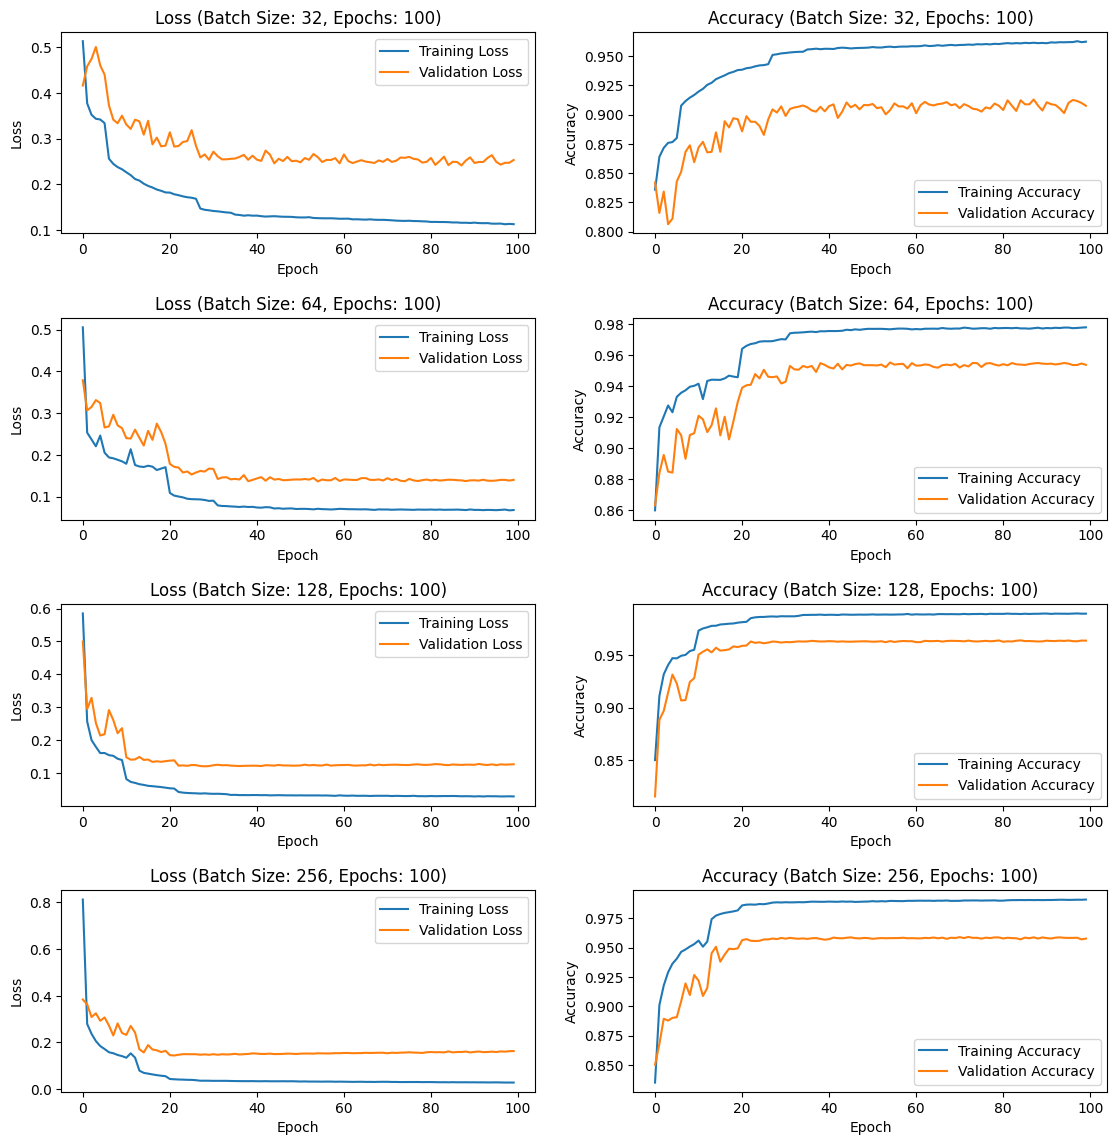

In [30]:
# Création de la figure et des axes pour chaque combinaison de batch_size et learning_rate
fig, axs = plt.subplots(len(batch_sizes) , 2, figsize=(12, 3 * len(batch_sizes) ))
fig.tight_layout(pad=4.0)

plot_index = 0  # Indice pour gérer la position actuelle du sous-graphique

# Correction de la récupération de l'objet History depuis la liste
for batch_size_ in batch_sizes:
    # Accéder correctement à l'objet History, qui est le premier élément de la liste
    training_results = results_dict[batch_size_][n_epochs][0].history

    # Configuration des graphiques pour la perte
    axs[plot_index, 0].plot(training_results['loss'], label='Training Loss')
    axs[plot_index, 0].plot(training_results['val_loss'], label='Validation Loss')
    axs[plot_index, 0].set_title(f'Loss (Batch Size: {batch_size_}, Epochs: {n_epochs})')
    axs[plot_index, 0].set_xlabel('Epoch')
    axs[plot_index, 0].set_ylabel('Loss')
    axs[plot_index, 0].legend()

    # Configuration des graphiques pour la précision
    axs[plot_index, 1].plot(training_results['accuracy'], label='Training Accuracy')
    axs[plot_index, 1].plot(training_results['val_accuracy'], label='Validation Accuracy')
    axs[plot_index, 1].set_title(f'Accuracy (Batch Size: {batch_size_}, Epochs: {n_epochs})')
    axs[plot_index, 1].set_xlabel('Epoch')
    axs[plot_index, 1].set_ylabel('Accuracy')
    axs[plot_index, 1].legend()

    plot_index += 1  # Mise à jour de l'indice pour le prochain sous-graphique

plt.show()


In [31]:
# 


#**16. Affichage de loss et accuracy pour le best model sur les données training. Attention pas nécessairement le meilleur modèle sur les données de test**

In [32]:
# Initialisation des variables pour suivre le meilleur modèle
best_model_info = None
best_val_accuracy = -1

# Itération à travers les combinaisons de batch_size et learning_rate
for batch_size_ in batch_sizes:
        # Accès aux informations du modèle courant
        model_info = results_dict[batch_size_][n_epochs]
        history = model_info[0].history  # Accès à l'objet History
        test_loss = model_info[1]
        test_accuracy = model_info[2]

        # Trouver la meilleure précision de validation
        max_val_accuracy = max(history['val_accuracy'])  # Max de la précision de validation pour le modèle courant
        if max_val_accuracy > best_val_accuracy:
            best_val_accuracy = max_val_accuracy
            best_model_info = (batch_size_, n_epochs, history, test_loss, test_accuracy)

# Affichage des informations du meilleur modèle
if best_model_info:
    batch_size_, n_epochs, history, test_loss, test_accuracy = best_model_info
    print(f"Meilleur Modèle - Batch Size: {batch_size_}, Epochs: {n_epochs}")
    print(f"Training Loss: {history['loss'][-1]}")
    print(f"Training Accuracy: {history['accuracy'][-1]}")
    print(f"Validation Loss: {history['val_loss'][-1]}")
    print(f"Validation Accuracy: {best_val_accuracy}")  # Déjà calculé
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}\n")


Meilleur Modèle - Batch Size: 128, Epochs: 100
Training Loss: 0.029829205945134163
Training Accuracy: 0.9899440407752991
Validation Loss: 0.12735728919506073
Validation Accuracy: 0.9643686413764954
Test Loss: 0.36958426237106323
Test Accuracy: 0.9175000190734863



#**17. Affichage de loss et accuracy pour les données de test par BS et LR**

In [33]:
# Étape 1: Collecter toutes les configurations
all_configurations_test = []

for batch_size_ in batch_sizes:
        # Extraire test_loss et test_accuracy pour chaque configuration
        test_loss = results_dict[batch_size_][n_epochs][1]
        test_accuracy = results_dict[batch_size_][n_epochs][2]

        # Ajouter la configuration et ses performances à la liste
        all_configurations_test.append({
            "batch_size": batch_size_,
            "epochs": n_epochs,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        })

# Étape 2: Trier les configurations par test_accuracy dans l'ordre décroissant
all_configurations_test.sort(key=lambda x: x["test_accuracy"], reverse=True)

# À ce stade, la meilleure configuration est déjà à l'index [0] grâce au tri

# Étape 3: Affichage pour vérification
print("Résultats sur les données de test (meilleure en premier) :")
for config in all_configurations_test:
    print(f"Batch Size: {config['batch_size']}, Epochs: {config['epochs']}, Test Loss: {config['test_loss']}, Test Accuracy: {config['test_accuracy']}")


Résultats sur les données de test (meilleure en premier) :
Batch Size: 256, Epochs: 100, Test Loss: 0.3566220998764038, Test Accuracy: 0.925000011920929
Batch Size: 128, Epochs: 100, Test Loss: 0.36958426237106323, Test Accuracy: 0.9175000190734863
Batch Size: 64, Epochs: 100, Test Loss: 0.3484060764312744, Test Accuracy: 0.9049999713897705
Batch Size: 32, Epochs: 100, Test Loss: 0.38768473267555237, Test Accuracy: 0.8675000071525574


#**19. Verification si la meilleur performance du modèle évalué sur les données test est confirmé?**

In [34]:
!mkdir -p modelest_model.h5
model_path_test = "/mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model_test.h5"

In [35]:
# Early Stopping call Back
early_patience = n_epochs

early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_patience)

checkpoint = ModelCheckpoint(model_path_test,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max', # Ensure that the best model in terms of val_accuracy is saved
                             verbose=1)

callbacks_list = [early_stopping, checkpoint]

In [39]:
# Création du modèle
model = get_model_3(input_shape, num_classes)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_test = model.fit(x,
                        np.array(y),
                        epochs=n_epochs,
                        validation_split=val_split,
                        shuffle=True,
                        batch_size=all_configurations_test[0]['batch_size'],
                        callbacks=callbacks_list)

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
# After training, load the best model
best_model_test = keras.models.load_model(model_path_test)
test_loss, test_accuracy = best_model_test.evaluate(x_test,np.array(y_test))

In [ ]:
best_model_test

In [ ]:
testing = process_csv_file('/mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/db/test/34281.csv')
reshaped_testing = np.array(testing).reshape(1, 437, 1)

pred = best_model_test.predict(reshaped_testing,batch_size=1)[0]


for (pos,prob) in enumerate(pred):
    class_name = int2id[pos]
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))